In [1]:
import numpy as np
import matplotlib.pyplot as plt
from core.activations import Fun
from core.losses import LossFun, mse
from core.mlp import MLP
from data.classification import get_classification_data, Size, ClassificationType
from utils.split import split_data

np.random.seed(42)

In [2]:
from collections import defaultdict

hidden_layers_num = [2]
hidden_layers_size = [32]
activations = [Fun.ReLU, Fun.Tanh, Fun.Sigmoid]
task_types = [ClassificationType.CIRCLES, ClassificationType.NOISY_XOR, ClassificationType.THREE_GAUSS]
task_size = Size._1000
epochs = 3000
learning_rate = 0.01

results = defaultdict(dict)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score

def evaluate_multiclass(model, X_test, y_test):
    """
    Oblicza accuracy i precision (macro-średnią) dla klasyfikacji wieloklasowej.
    """
    y_pred = model.forward(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_pred = np.eye(y_pred.shape[1])[y_pred_class]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)

    return acc, prec


In [4]:
import itertools

for task_type in task_types:
    X, Y = get_classification_data(task_type, task_size)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, Y)
    for hl_num in hidden_layers_num:
        for layer_sizes in itertools.product(hidden_layers_size, repeat=hl_num):
            for layer_activations in activations:
                
                layer_sizes_full = [2] + list(layer_sizes) + [Y.shape[1]]
                activations_full = [layer_activations] * hl_num + [Fun.Linear]
                mlp = MLP(layer_sizes_full, activations_full, LossFun.MSE)
                accuracies = []
                precisions = []

                for _ in range(epochs//10):
                    mlp.train(X_train, y_train, X_val, y_val, epochs=10, learning_rate=learning_rate)
                    acc, prec = evaluate_multiclass(mlp, X_test, y_test)
                    accuracies.append(acc)
                    precisions.append(prec)

                test_predictions = mlp.forward(X_test)
                test_loss = mse(test_predictions, y_test)

                config_key = f"{list(layer_sizes)}, {layer_activations.name}"
                
                results[task_type][config_key] = {
                    "accuracies": accuracies,
                    "precisions": precisions,
                    "test_loss": test_loss
                }
                print(f"Completed: {config_key} with Test Loss: {test_loss}")

Completed: [32, 32], ReLU with Test Loss: 0.07605952594659858
Completed: [32, 32], Tanh with Test Loss: 0.0892527961744725
Completed: [32, 32], Sigmoid with Test Loss: 0.17948909593808138
Completed: [32, 32], ReLU with Test Loss: 0.05603047022226402
Completed: [32, 32], Tanh with Test Loss: 0.08150548334565232
Completed: [32, 32], Sigmoid with Test Loss: 0.24854059961602318
Completed: [32, 32], ReLU with Test Loss: 0.0411871521987159
Completed: [32, 32], Tanh with Test Loss: 0.06300394931187925
Completed: [32, 32], Sigmoid with Test Loss: 0.18281948287939914


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_classification_metrics(results):
    """
    Tworzy wykresy Accuracy i Precision w jednym subplocie dla każdego zadania.
    Na jednym wykresie znajdują się krzywe dla wszystkich funkcji aktywacji.
    Oś X odpowiada rzeczywistej liczbie epok (np. 10, 20, 30...).
    """
    for task_type, configs in results.items():
        # Grupowanie wyników po aktywacji
        data_by_activation = {}
        for config_key, metrics in configs.items():
            try:
                # np. "[32, 32], ReLU" → aktywacja = "ReLU"
                _, activation_str = config_key.split("],")
                activation = activation_str.strip().strip(",").strip()
            except Exception:
                activation = "Unknown"

            data_by_activation.setdefault(activation, []).append(metrics)

        # Przygotowanie wykresów
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        ax_acc, ax_prec = axes

        for activation, metrics_list in data_by_activation.items():
            # Uśrednianie accuracy
            max_len = max(len(m["accuracies"]) for m in metrics_list)
            acc_matrix = np.array([np.pad(m["accuracies"], (0, max_len - len(m["accuracies"])), constant_values=np.nan)
                                   for m in metrics_list])
            mean_acc = np.nanmean(acc_matrix, axis=0)

            # Uśrednianie precision
            prec_matrix = np.array([np.pad(m["precisions"], (0, max_len - len(m["precisions"])), constant_values=np.nan)
                                    for m in metrics_list])
            mean_prec = np.nanmean(prec_matrix, axis=0)

            epochs_scaled = np.arange(1, len(mean_acc) + 1) * 10  # przeskalowana oś X

            # --- wykres accuracy ---
            ax_acc.plot(epochs_scaled, mean_acc, label=activation)
            # --- wykres precision ---
            ax_prec.plot(epochs_scaled, mean_prec, label=activation)

        # Ustawienia osi
        ax_acc.set_title("Accuracy")
        ax_acc.set_xlabel("Epoki")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.grid(True)
        ax_acc.legend(title="Aktywacja")

        ax_prec.set_title("Precision")
        ax_prec.set_xlabel("Epoki")
        ax_prec.set_ylabel("Precision")
        ax_prec.grid(True)
        ax_prec.legend(title="Aktywacja")

        fig.suptitle(f"Wyniki dla zadania: {task_type.name}", fontsize=14)
        fig.tight_layout()
        plt.show()


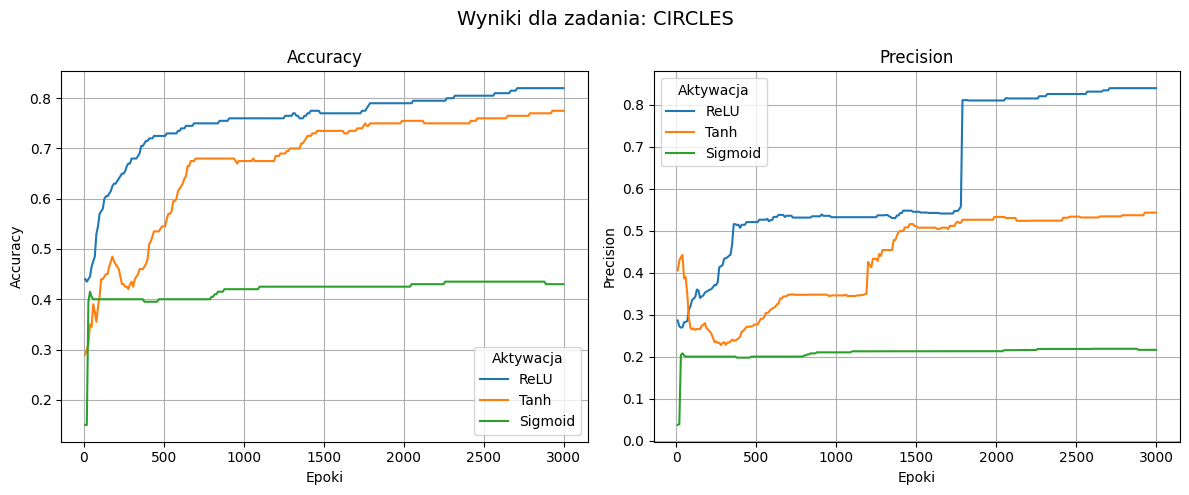

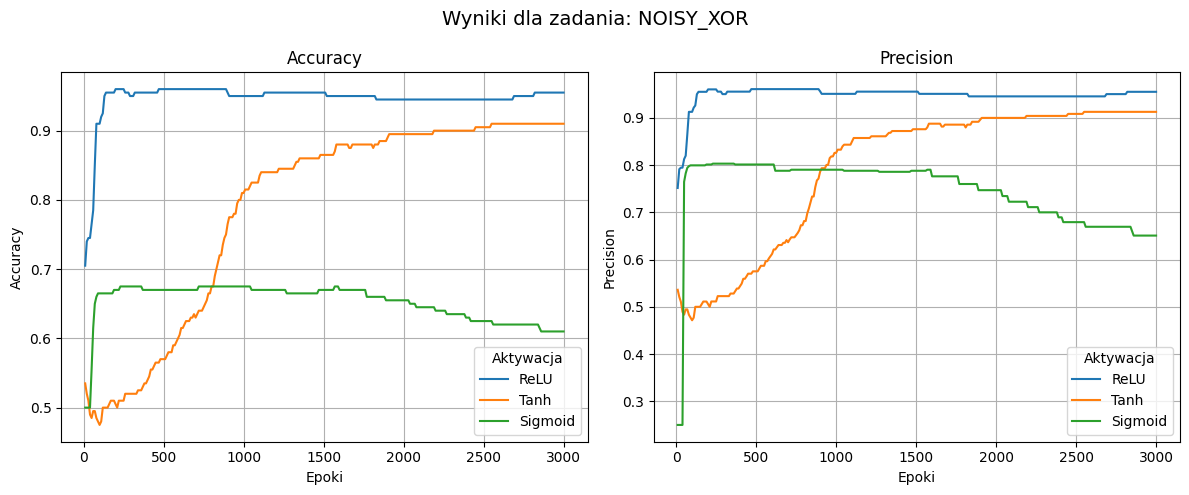

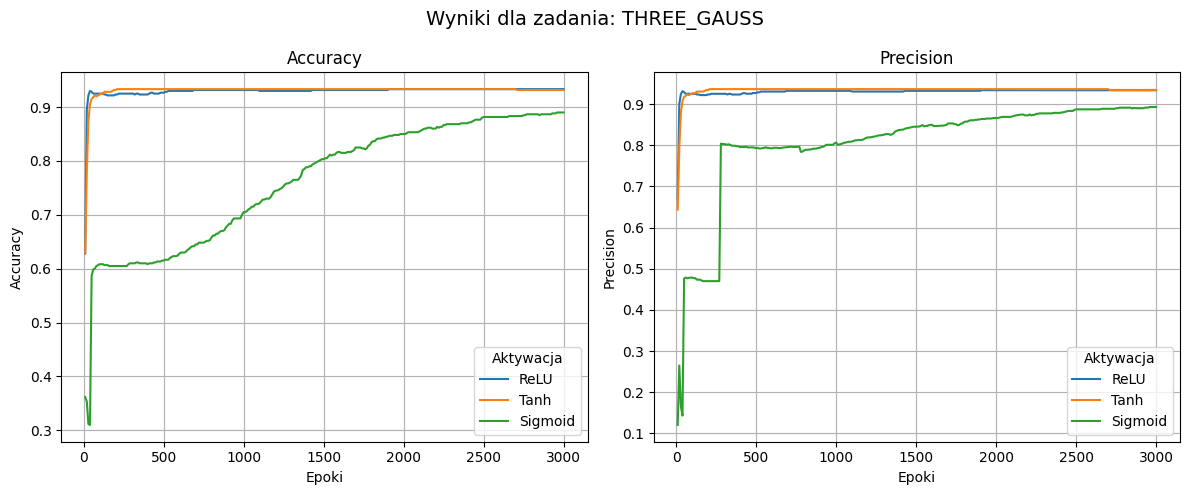

In [9]:
plot_classification_metrics(results)
